In [1]:
## Python Script for the Final Project, Stats 506 F20
##
## For adults who weigh less than they were 10 years ago, what types of nutrient
## intake and what demographic variables play an important role?
##
## Data source: National Health and Nutrition Examination Survey (NHANES)
## https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016
## https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018 
##
## Author: Yingyi Yang, yyingyi@umich.edu
## Updated: December 6, 2020

#! Limit lines to 79 characters with rare exceptions. 
# 79: -------------------------------------------------------------------------

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

### 1. Data preprocessing 

In [17]:
def prep_data(year):
    """
    Function to read nhanes data based on year codes and merge them into one dataframe.
    Input: year - list of alphabet representing year of concern
    Output: a dataframe containing required covariates and response variable
    """
    
    base = 'data/'
    
    files = []
    
    var = [
        ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2'],
        ['SEQN', 'DR1DRSTZ', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 
         'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL'],
        ['SEQN', 'WHD020', 'WHD110']
    ]
    
    out = pd.DataFrame()
    for code in year:
        names = [x+'_'+code+'.XPT' for x in ['DEMO', 'DR1TOT', 'WHQ']]

        da = []
        for idf, fn in enumerate(names):
            df = pd.read_sas(os.path.join(base, fn))
            df = df.loc[:, var[idf]]
            da.append(df)
            
        dx = pd.merge(da[0], da[1], left_on='SEQN', right_on='SEQN')
        dx = pd.merge(dx, da[2], left_on='SEQN', right_on='SEQN')

        # encode sex and ethnic groups
        dx['Female'] = (dx.RIAGENDR == 2).astype(np.int)
        #dx['RIDRETH1'] = dx.RIDRETH1.replace({1: 'Mexican American', 2: 'Other Hispanic', 
        #                                     3: 'Non-Hispanic White', 4: 'Non-Hispanic Black', 
        #                                     5: 'other'})
        
        dx.dropna(inplace = True)
        out = out.append(dx)
    
    out['Wloss'] = (out['WHD020'] < out['WHD110']-5.0).astype(np.int)
    out = out[out['DR1DRSTZ'] == 1]
    del out['RIAGENDR']
    del out['WHD020']
    del out['WHD110']
    del out['DR1DRSTZ']
    out.set_index('SEQN', inplace=True)
    
    return out    

In [19]:
df = prep_data(['I','J'])
df.shape

(6983, 16)

In [21]:
df.head()

,RIDAGEYR,RIDRETH1,DMDEDUC2,INDHHIN2,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,Female,Wloss
SEQN,,,,,,,,,,,,,,,,
83732.0,62.0,3.0,5.0,10.0,1781.0,76.03,193.29,42.31,23.6,79.24,23.430,31.897,18.528,138.0,0,1
83733.0,53.0,3.0,3.0,4.0,2964.0,62.36,356.85,180.84,7.3,77.91,25.722,19.098,19.216,407.0,0,0
83734.0,78.0,3.0,3.0,5.0,2482.0,116.50,304.53,62.87,35.1,91.97,23.122,28.666,32.561,506.0,0,1
83735.0,56.0,3.0,5.0,10.0,1340.0,70.38,157.99,54.77,14.0,49.23,17.593,18.327,9.588,138.0,1,0
83736.0,42.0,4.0,4.0,7.0,604.0,19.30,90.30,71.84,2.0,19.63,4.581,8.504,3.889,96.0,1,0


### 2. Feature selection 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
import seaborn as sns

In [22]:
def featureSelection(data, n, method = 'Model_LR'):
    """
    Function to fit model and generate features based on the input method.
    Inputs: data - a dataframe containing covariates and response variable
            n - an integer representing top n important features
            method - a string containing feature selection method 
            (Model: model-based, RFE: recursive feature elimination) and model 
            (LR: logistic regression, tree: decision tree)
    Output: a figure representing feature importance
    """
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    if method == 'Model_LR':
        LR = LogisticRegression()
        LR.fit(X, y)
        coefs = LR.coef_
        feature_coefs = pd.DataFrame({'Feature name':X.columns.values, 
                                      'Feature coef':coefs[0]}).sort_values('Feature coef', ascending=False)

        imp_coef = pd.concat([feature_coefs.head(int(n/2)),
                             feature_coefs.tail(int(n/2))])

        plt.figure(figsize=(6,6))
        plt.title("Coefficients")
        sns.barplot(x="Feature coef", y="Feature name", data=imp_coef)  
    
    if method == 'Model_tree':
        tree = DecisionTreeClassifier()
        tree.fit(X, y)      
        importances = tree.feature_importances_
        feature_importance = pd.DataFrame({'Feature name':X.columns.values, 
                                           'Feature importance':importances}
                                         ).sort_values('Feature importance', ascending=False)

        plt.figure(figsize=(6,6))
        plt.title("Feature Importance")
        sns.barplot(x="Feature importance", y="Feature name", data=feature_importance[:n])
        
    if method == 'RFE_LR':
        LR = LogisticRegression()
        trans = RFE(LR, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        columns = X.columns.values
        print(columns[trans.get_support()])
        for i in range(X.shape[1]):
            print('Variable: %s, Selected %s, Rank: %.3f' % 
                  (columns[i], trans.support_[i], trans.ranking_[i]))
        
    if method == 'RFE_tree':
        tree = DecisionTreeClassifier()
        trans = RFE(tree, n_features_to_select=n)
        X_trans = trans.fit_transform(X, y)
        columns = X.columns.values
        print(columns[trans.get_support()])
        for i in range(X.shape[1]):
            print('Variable: %s, Selected %s, Rank: %.3f' % 
                  (columns[i], trans.support_[i], trans.ranking_[i]))       

### 3. Results visualization 

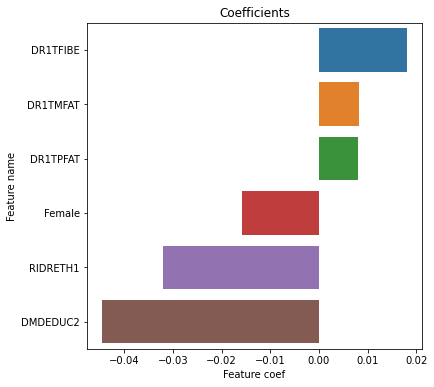

In [23]:
featureSelection(df, 6, 'Model_LR')

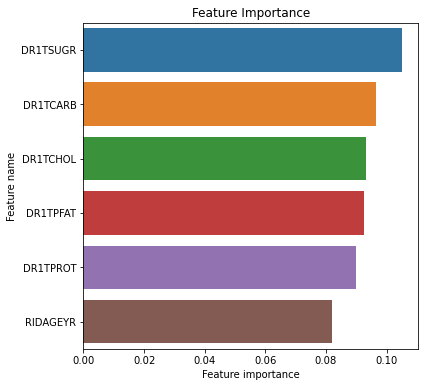

In [24]:
featureSelection(df, 6, 'Model_tree')

In [25]:
featureSelection(df, 6, 'RFE_LR')

['RIDAGEYR' 'DMDEDUC2' 'DR1TTFAT' 'DR1TMFAT' 'DR1TPFAT' 'Female']
Variable: RIDAGEYR, Selected True, Rank: 1.000
Variable: RIDRETH1, Selected False, Rank: 3.000
Variable: DMDEDUC2, Selected True, Rank: 1.000
Variable: INDHHIN2, Selected False, Rank: 7.000
Variable: DR1TKCAL, Selected False, Rank: 10.000
Variable: DR1TPROT, Selected False, Rank: 8.000
Variable: DR1TCARB, Selected False, Rank: 5.000
Variable: DR1TSUGR, Selected False, Rank: 6.000
Variable: DR1TFIBE, Selected False, Rank: 4.000
Variable: DR1TTFAT, Selected True, Rank: 1.000
Variable: DR1TSFAT, Selected False, Rank: 2.000
Variable: DR1TMFAT, Selected True, Rank: 1.000
Variable: DR1TPFAT, Selected True, Rank: 1.000
Variable: DR1TCHOL, Selected False, Rank: 9.000
Variable: Female, Selected True, Rank: 1.000


In [26]:
featureSelection(df, 6, 'RFE_tree')

['DR1TKCAL' 'DR1TFIBE' 'DR1TSFAT' 'DR1TMFAT' 'DR1TPFAT' 'DR1TCHOL']
Variable: RIDAGEYR, Selected False, Rank: 5.000
Variable: RIDRETH1, Selected False, Rank: 8.000
Variable: DMDEDUC2, Selected False, Rank: 9.000
Variable: INDHHIN2, Selected False, Rank: 7.000
Variable: DR1TKCAL, Selected True, Rank: 1.000
Variable: DR1TPROT, Selected False, Rank: 3.000
Variable: DR1TCARB, Selected False, Rank: 4.000
Variable: DR1TSUGR, Selected False, Rank: 2.000
Variable: DR1TFIBE, Selected True, Rank: 1.000
Variable: DR1TTFAT, Selected False, Rank: 6.000
Variable: DR1TSFAT, Selected True, Rank: 1.000
Variable: DR1TMFAT, Selected True, Rank: 1.000
Variable: DR1TPFAT, Selected True, Rank: 1.000
Variable: DR1TCHOL, Selected True, Rank: 1.000
Variable: Female, Selected False, Rank: 10.000
